In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
sample = "mm34"
reduced = ""

reference = pd.read_csv(rf'../data/input_data/{sample}/ref{reduced}.csv', index_col=0)
alternative = pd.read_csv(rf'../data/input_data/{sample}/alt{reduced}.csv', index_col=0)

In [4]:
vaf = alternative/(reference+alternative)

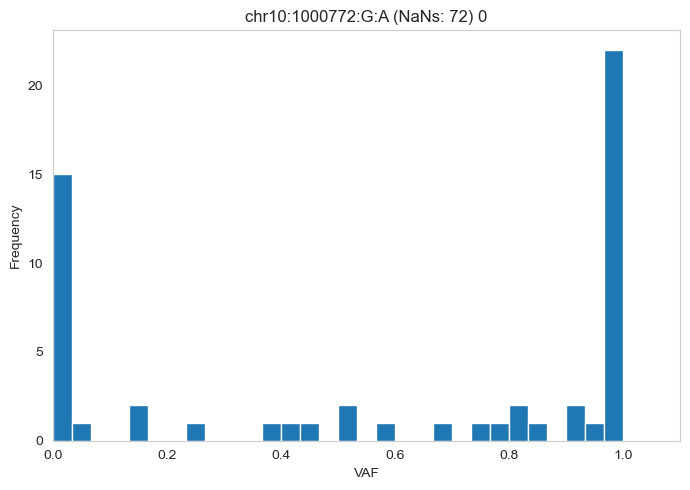

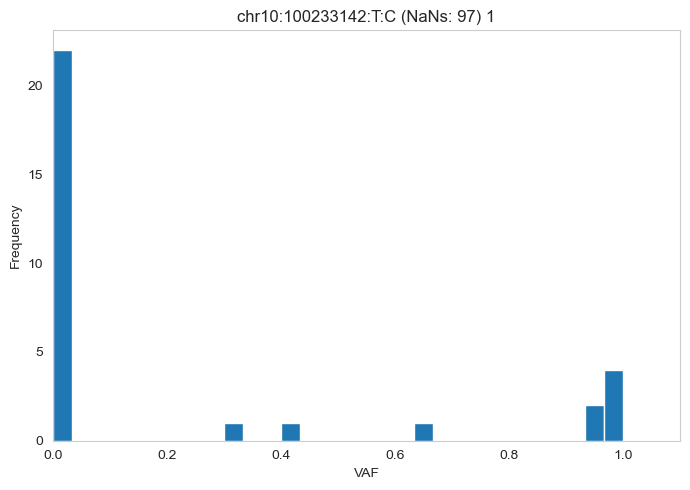

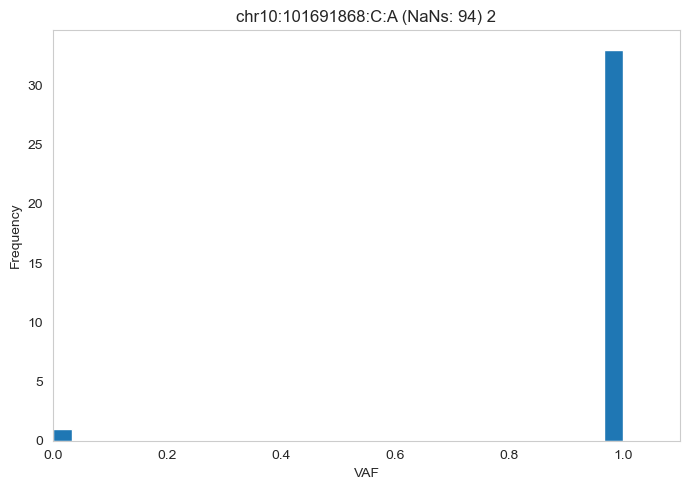

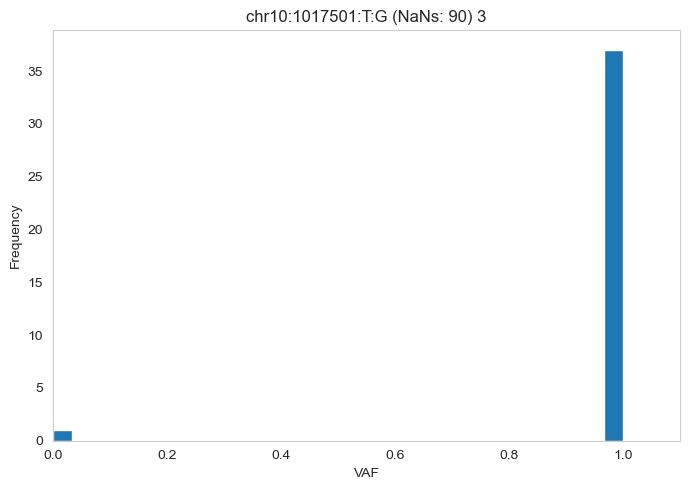

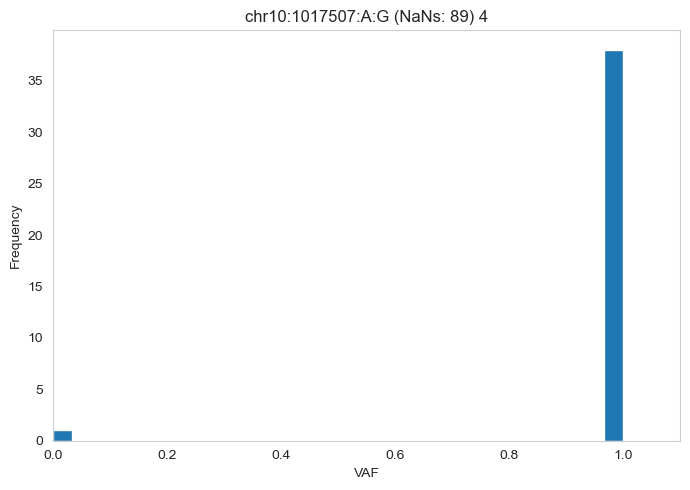

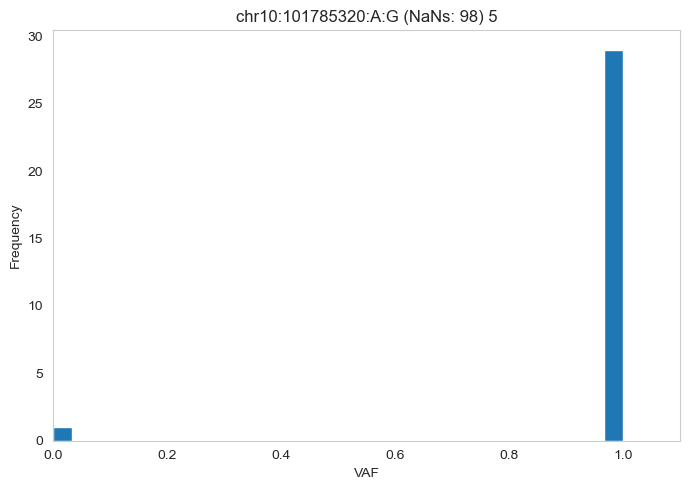

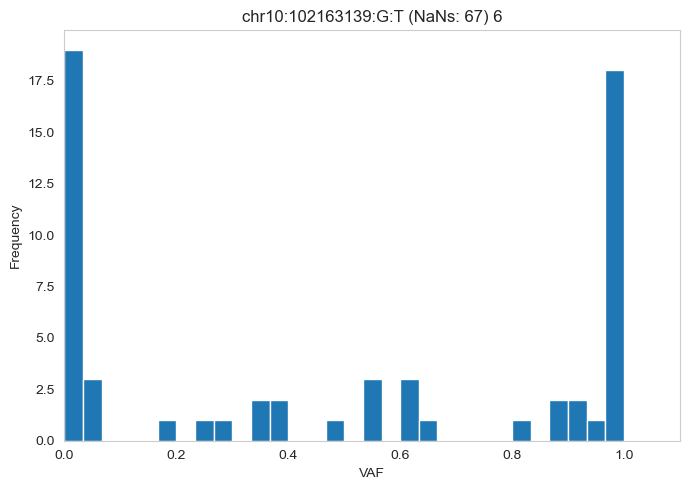

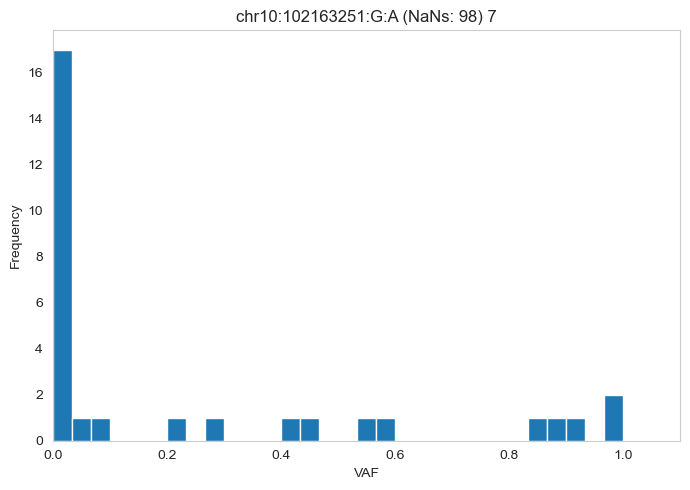

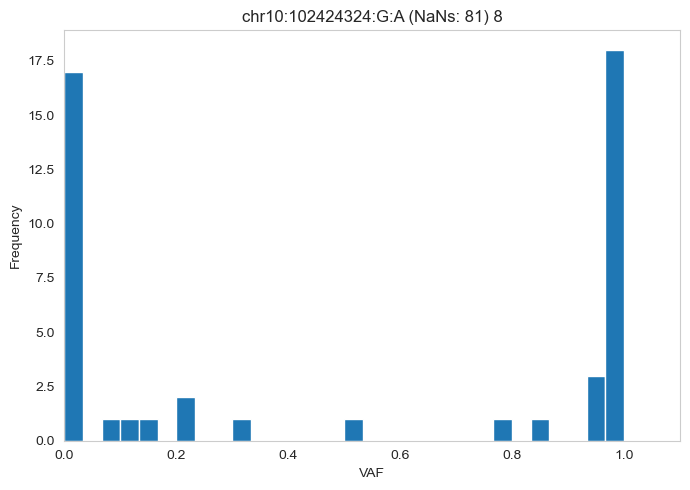

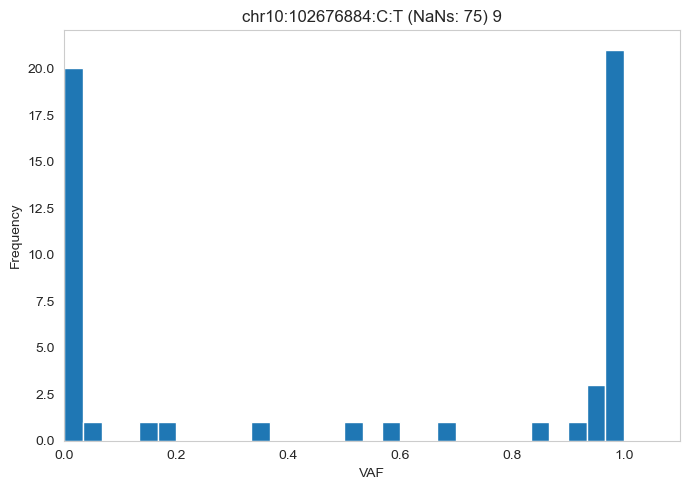

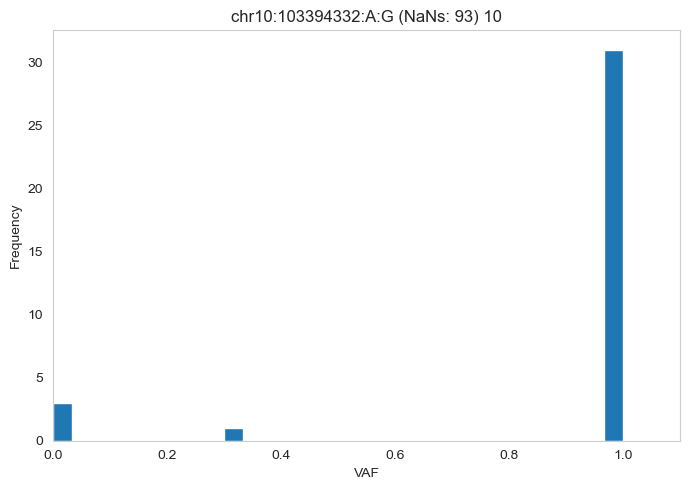

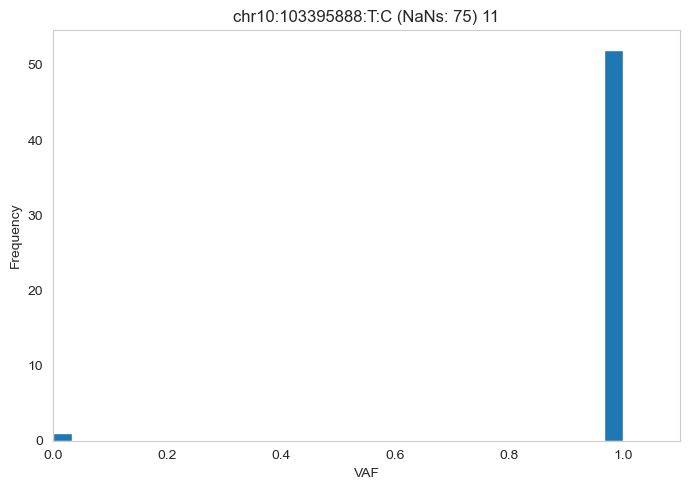

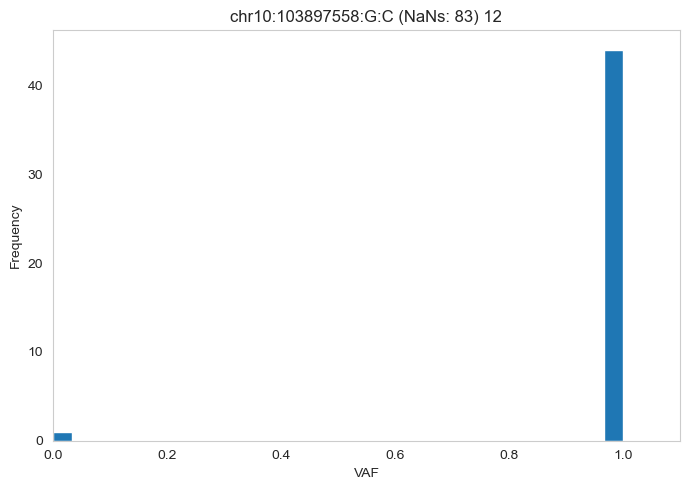

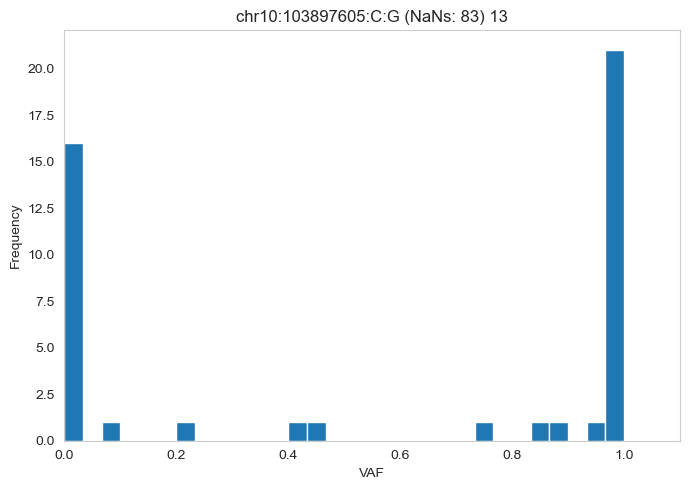

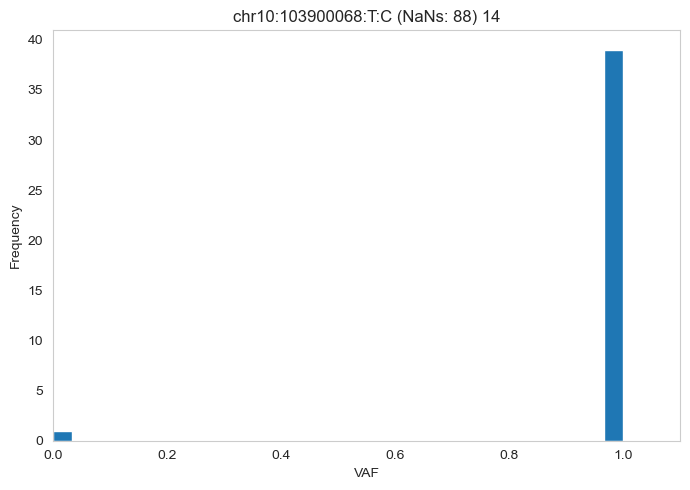

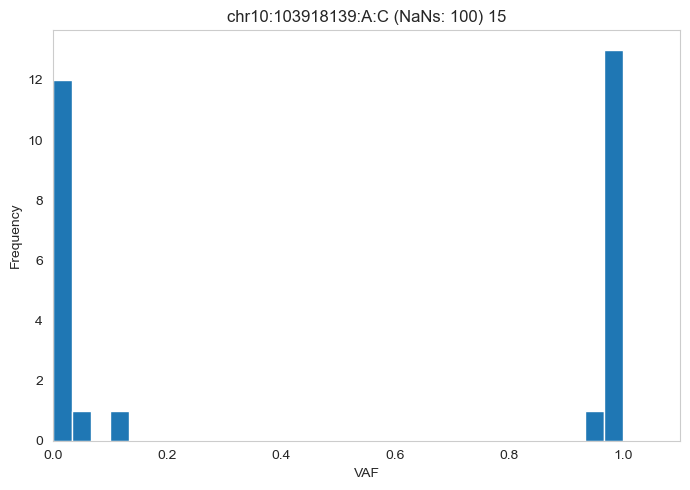

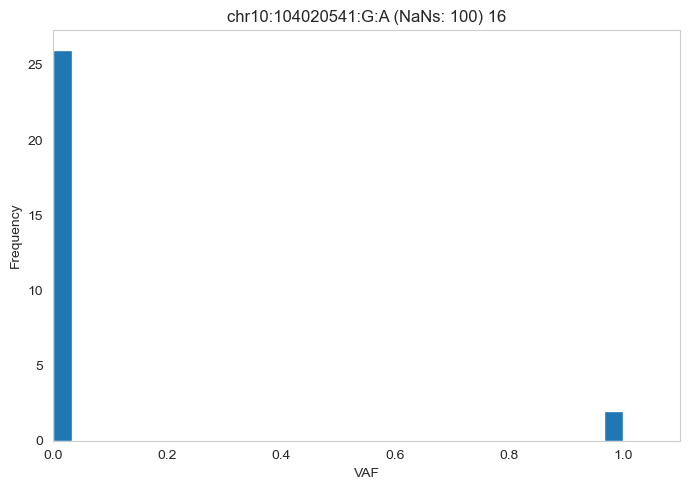

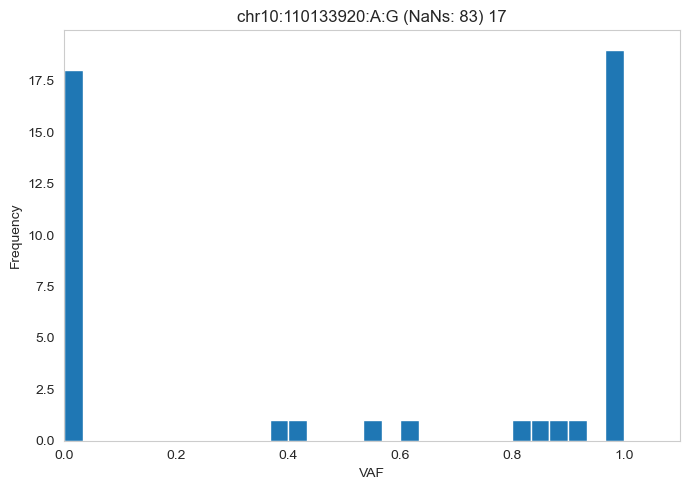

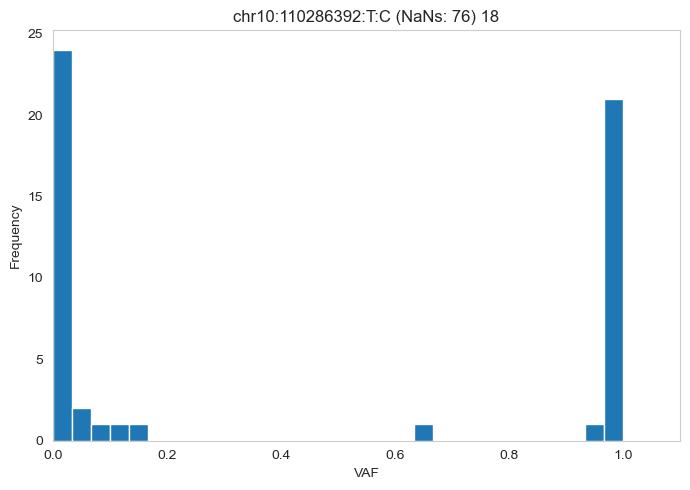

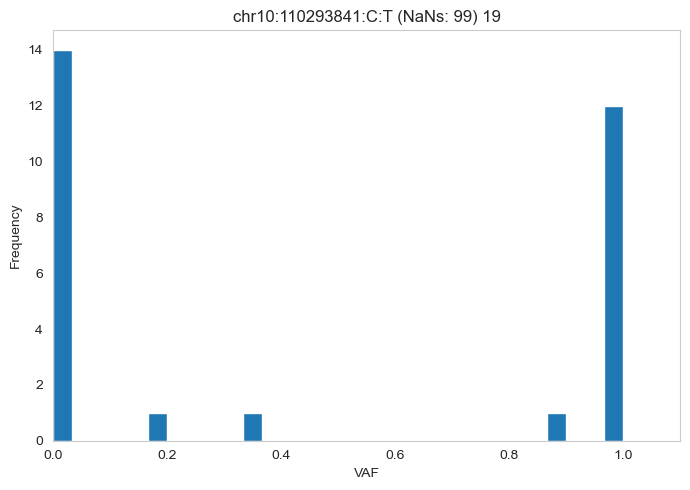

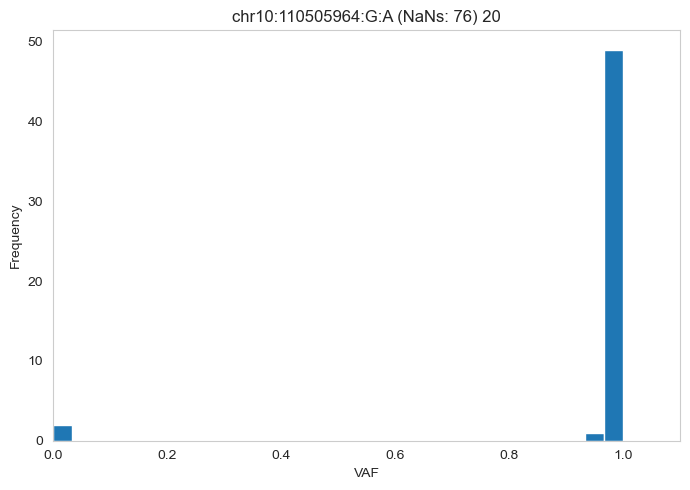

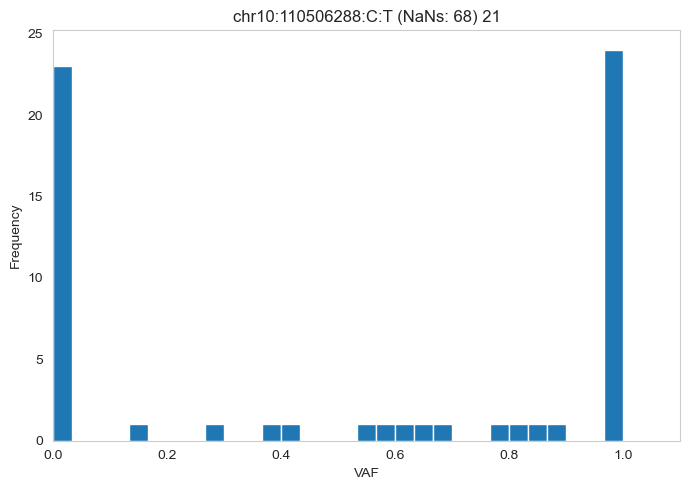

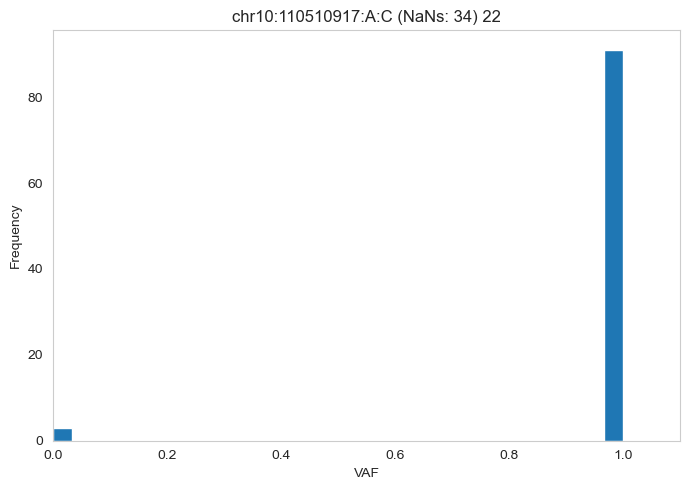

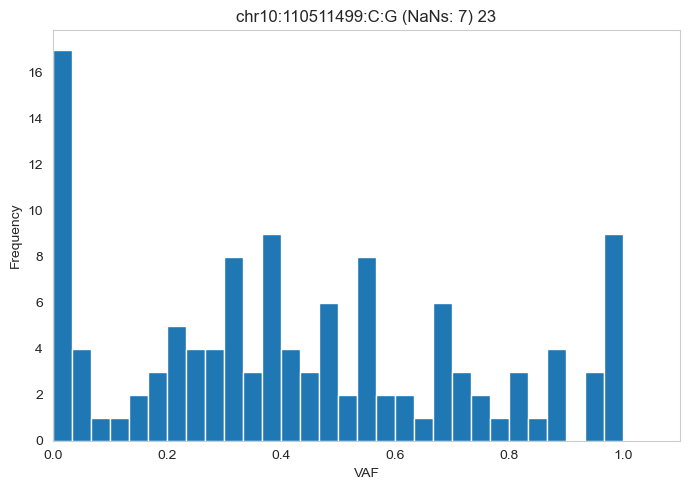

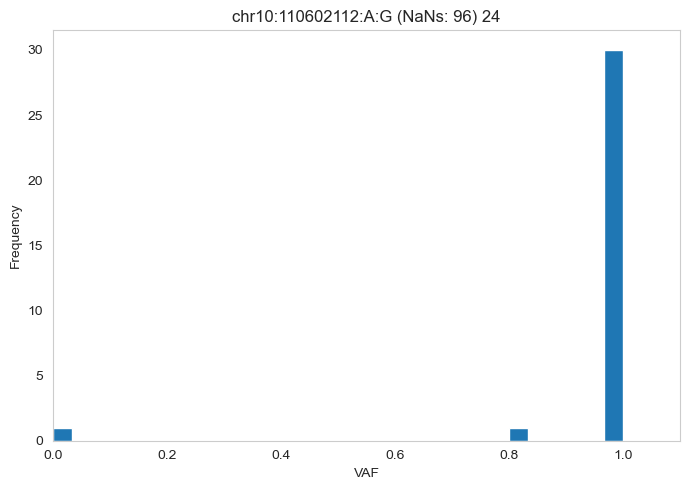

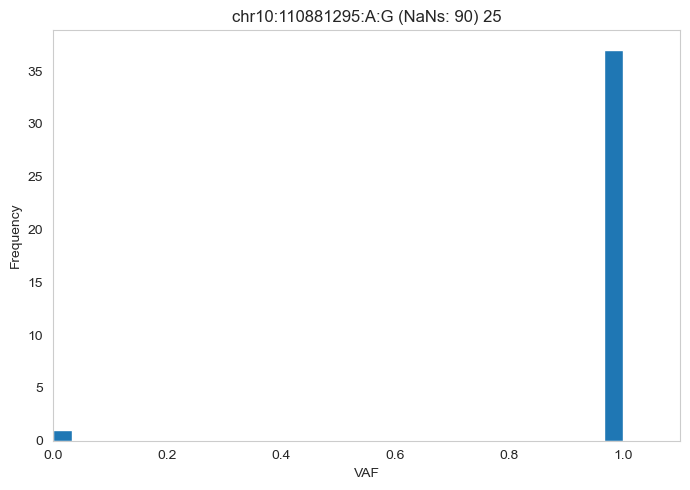

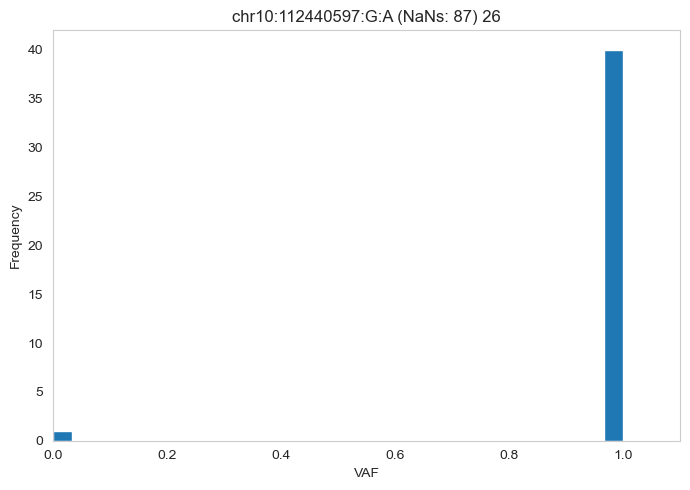

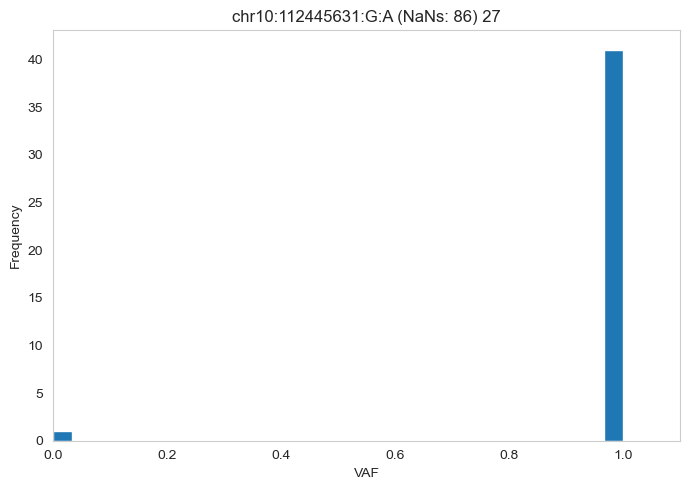

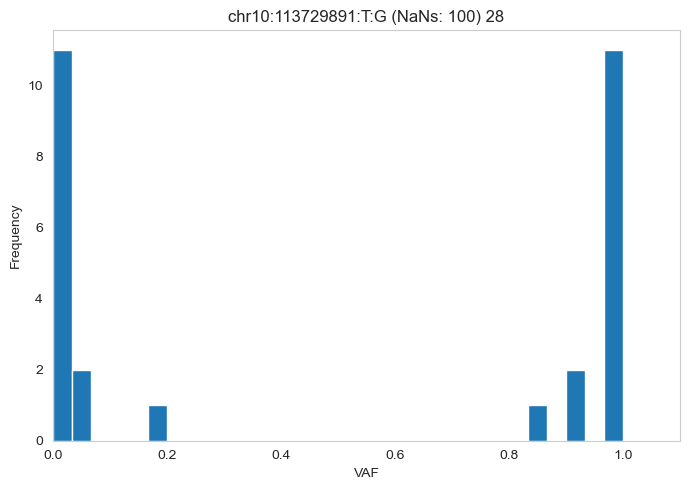

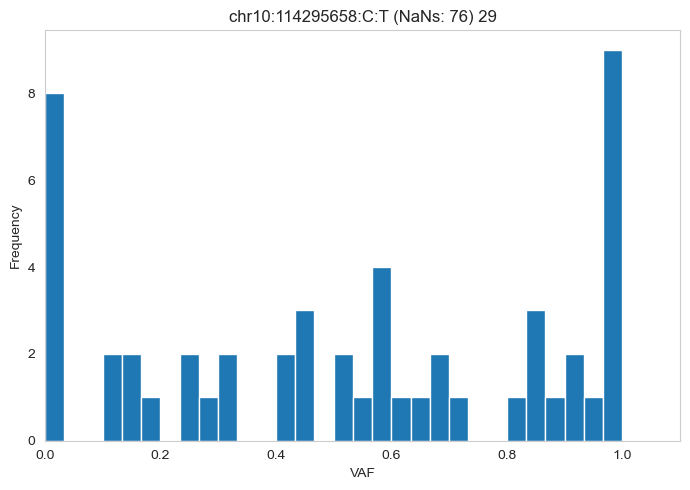

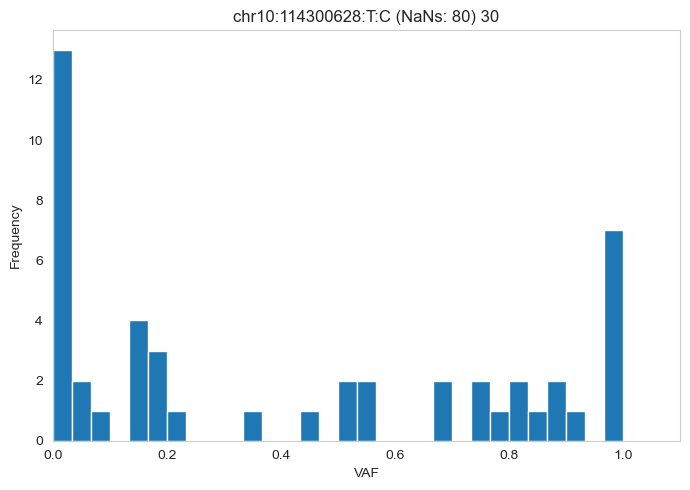

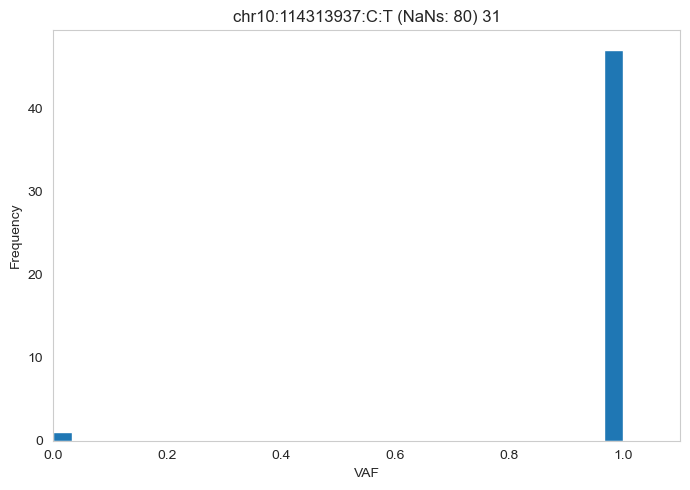

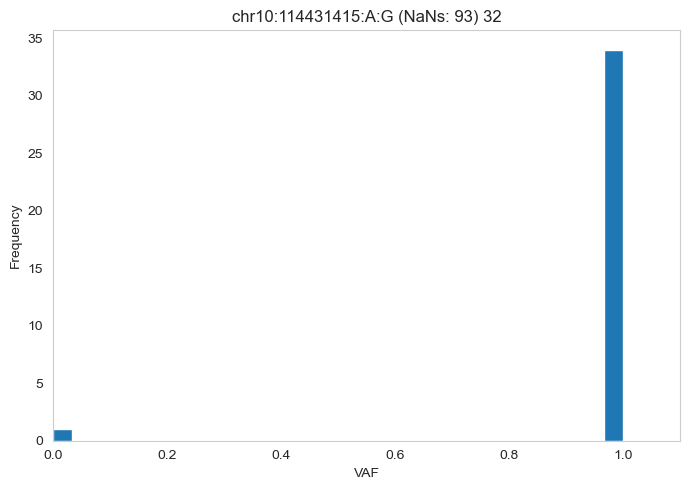

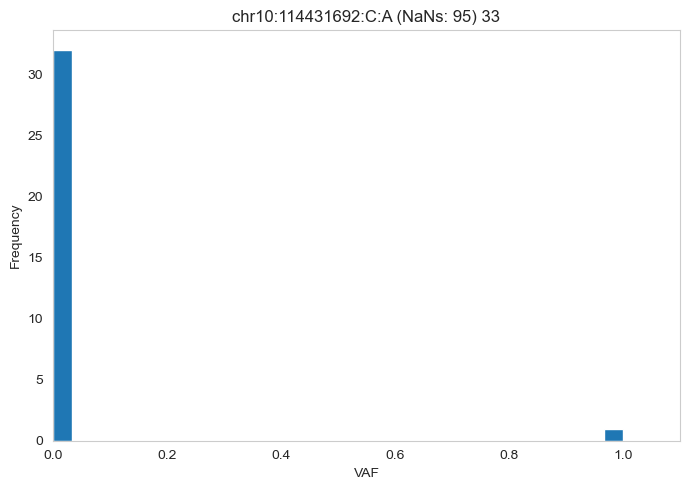

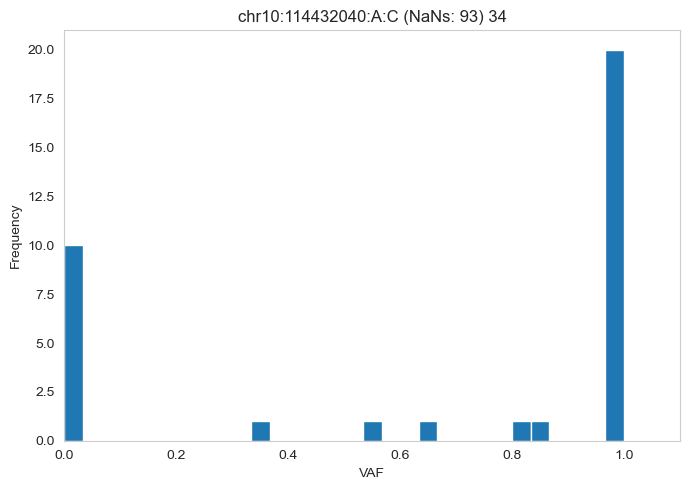

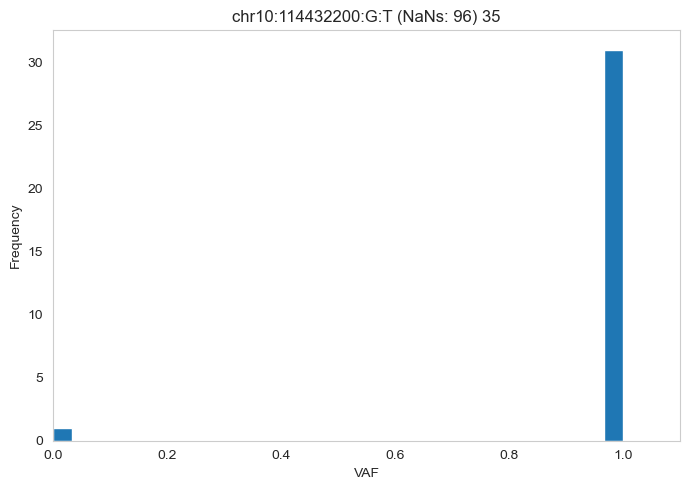

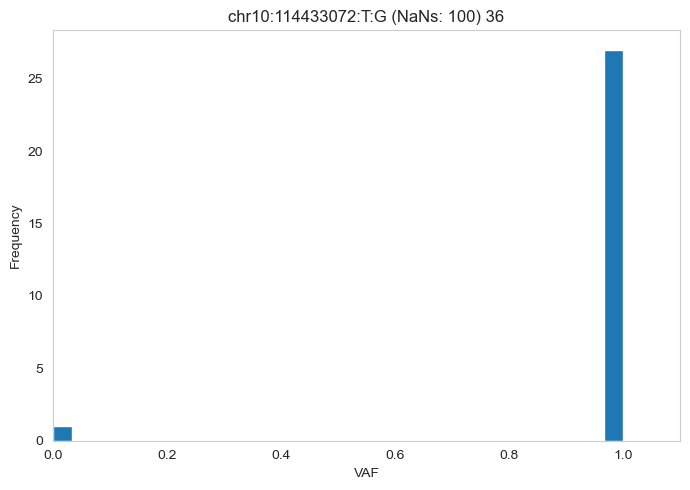

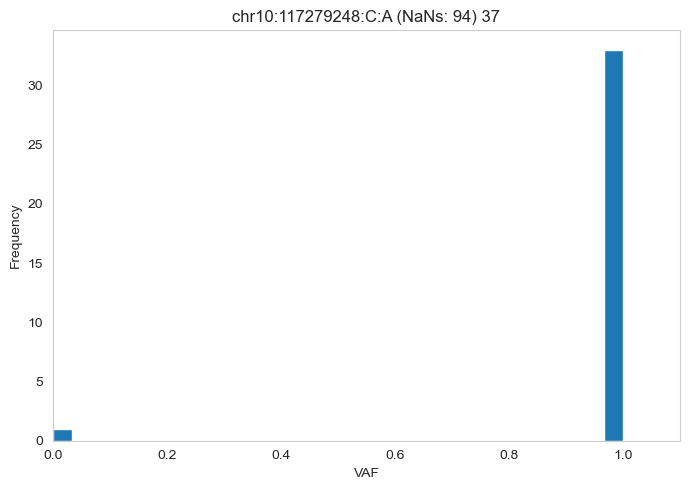

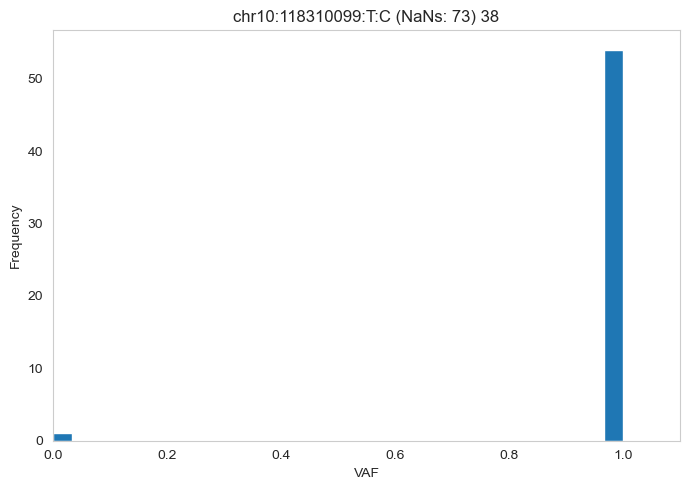

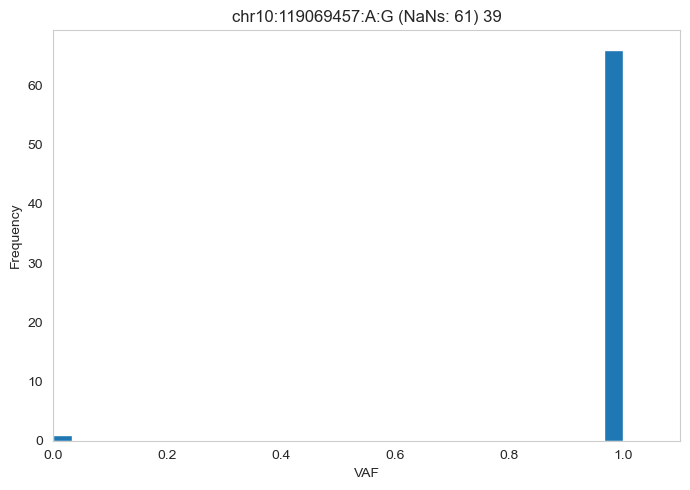

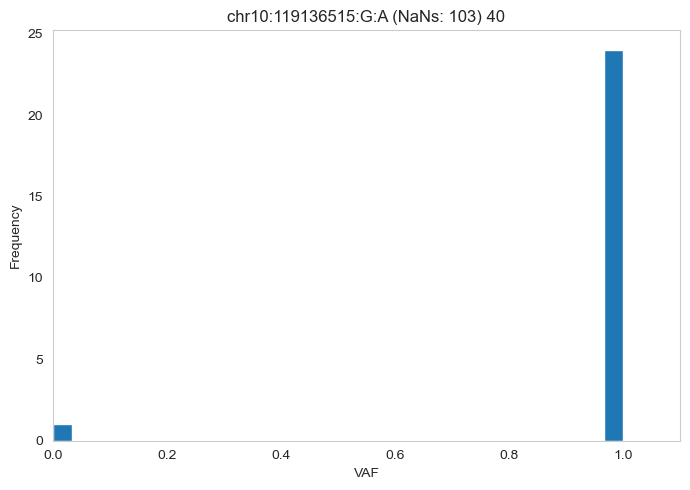

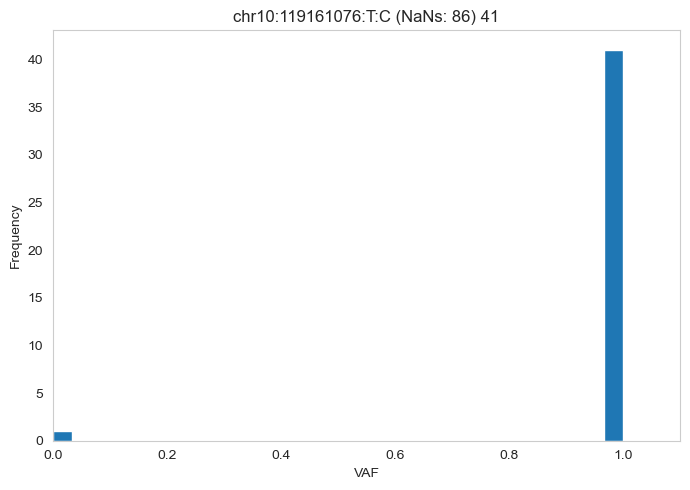

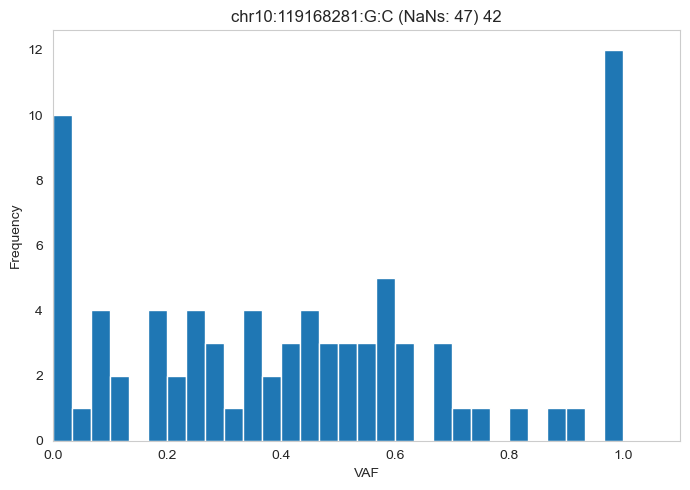

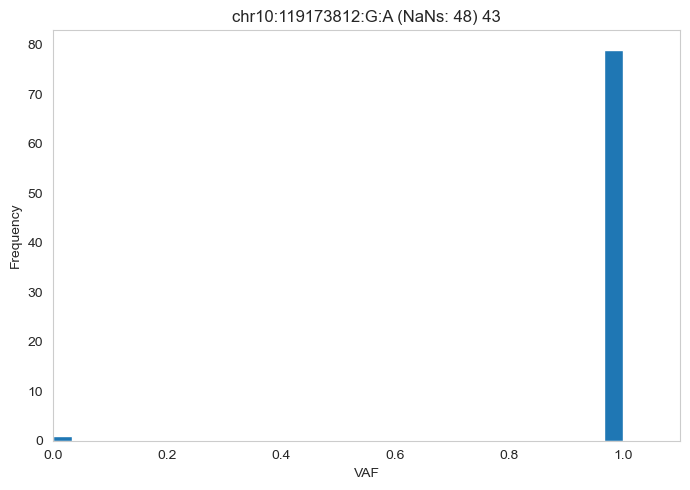

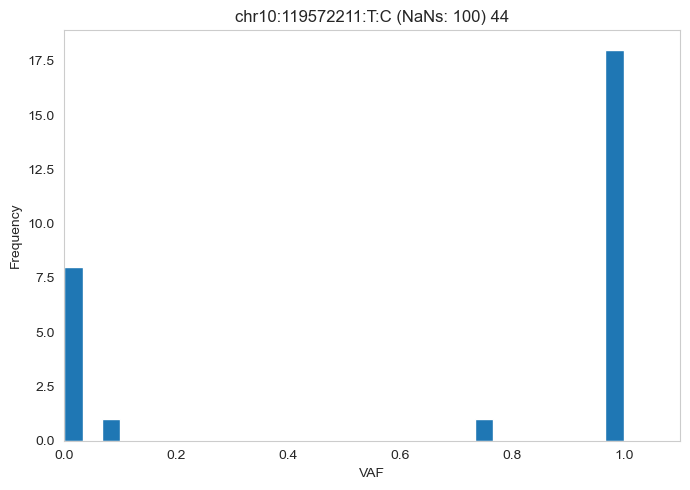

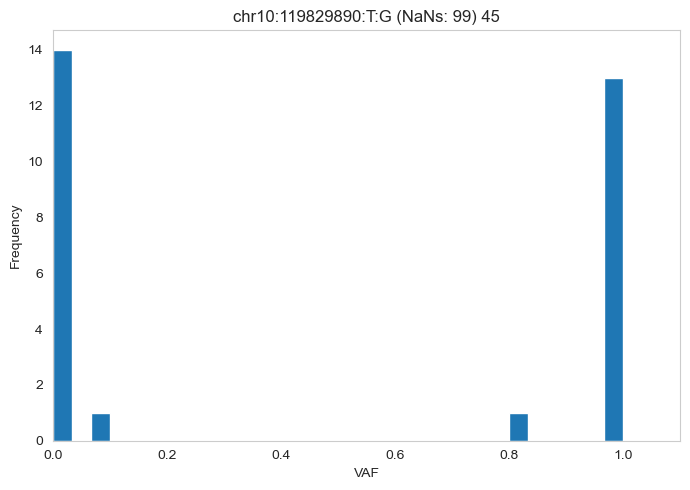

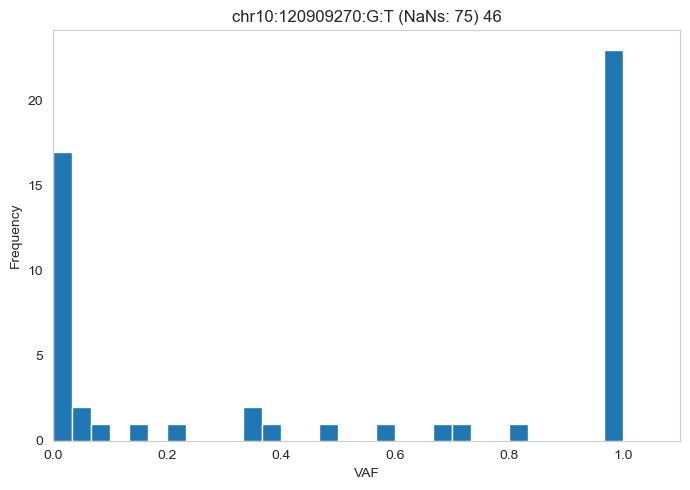

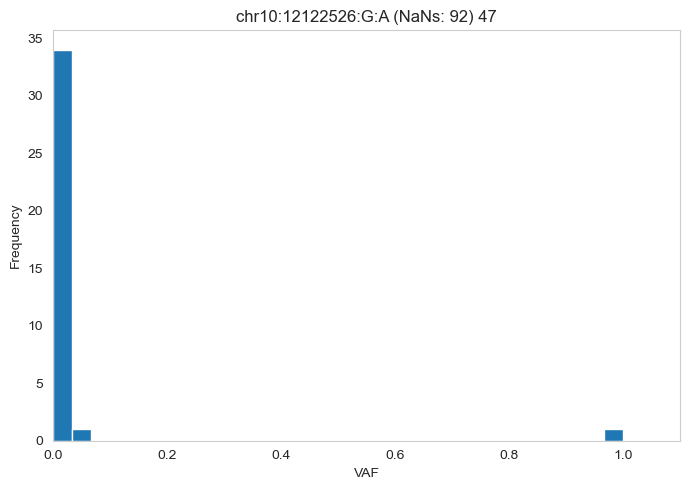

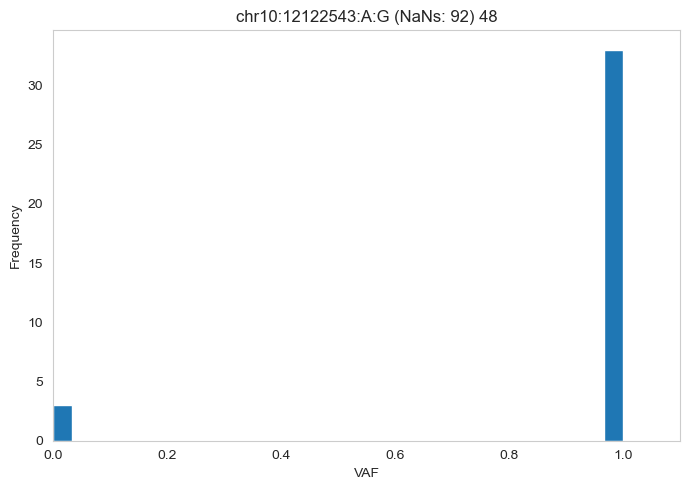

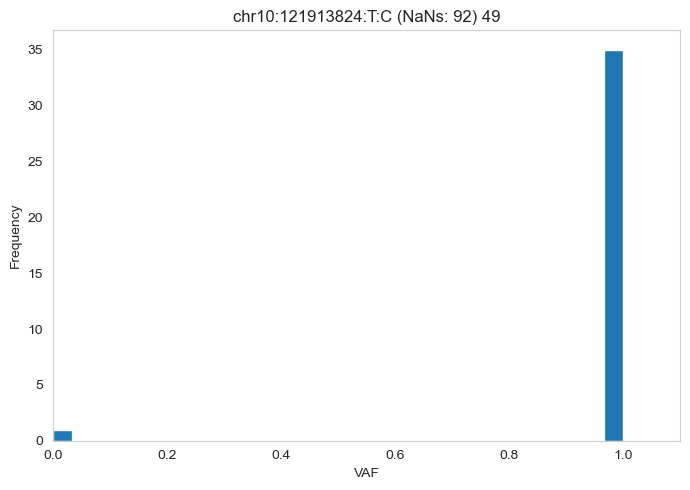

In [18]:
n = 50
num_cols = min(n, len(vaf.columns))
df_subset = vaf.iloc[:, :num_cols]

for n, col in enumerate(df_subset.columns):
    nan_count = vaf[col].isna().sum()
    plt.figure(figsize=(7, 5))
    vaf_red = list(vaf[col].dropna())
    vaf_red.append(0)
    plt.hist(vaf_red, bins=30)
    plt.title(f'{col} (NaNs: {nan_count}) {n}')
    plt.xlabel('VAF')
    plt.ylabel('Frequency')
    plt.xlim([0, 1.1])
    plt.tight_layout()
    plt.grid(False)
    plt.show()

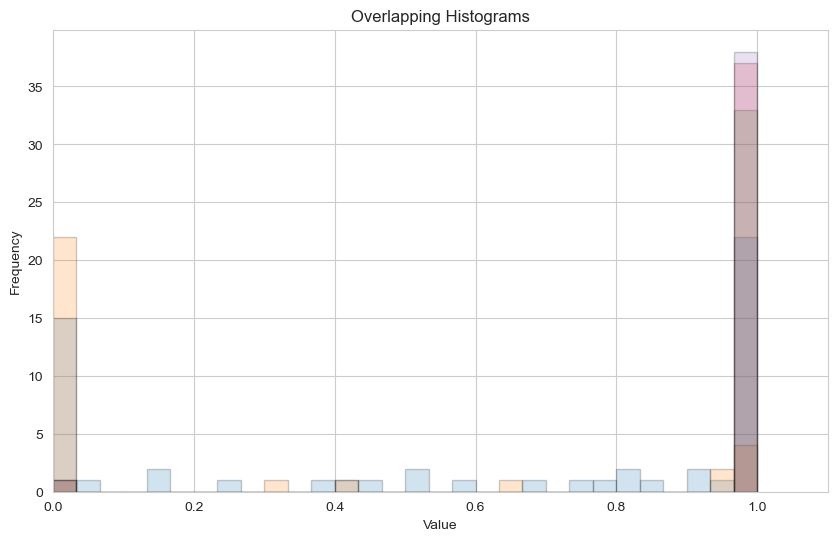

In [6]:
n=5

num_cols = min(n, len(vaf.columns))
df_subset = vaf.iloc[:, :num_cols]

plt.figure(figsize=(10, 6))

for col in df_subset.columns:
    nan_count = vaf[col].isna().sum()
    vaf_red = list(vaf[col].dropna())
    vaf_red.append(0)
    plt.hist(vaf_red, bins=30, alpha=0.2, edgecolor='black')

plt.title('Overlapping Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim([0, 1.1])
# plt.legend()
plt.show()

0.999
0.001
0.5


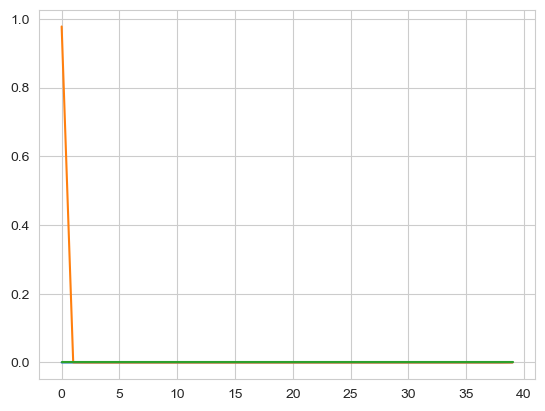

In [7]:
from scipy.special import gamma

eps=0.001
n_ref_alleles = 1
n_alt_alleles = 1
omega_hom = 20
omega_het = 50
coverage = 40

def likelihood_dropout(alt_count, ref_count, f, omega):
    numerator = gamma(alt_count + omega * f) * gamma(ref_count + omega * (1 - f))
    denominator = gamma(alt_count + ref_count + omega) * gamma(omega * f) * gamma(omega * (1 - f))
    likelihood = numerator / denominator * gamma(omega)
    return likelihood

for n_ref in range(n_ref_alleles+1):
    for n_alt in range(n_alt_alleles+1):
        if n_alt ==  0 and n_ref == 0:
            continue
            
        if n_ref == 0 or n_alt == 0:
            omega = omega_hom
        else:
            omega = omega_het
            
        f = n_alt/(n_ref+n_alt) * (1-eps) + n_ref/(n_ref+n_alt) * eps 
        print(f)
        
        likelihoods = []
        for c in range(coverage):
            likelihoods.append(likelihood_dropout(c, coverage-c, f, omega))
            
        plt.plot(likelihoods)
        # plt.show()

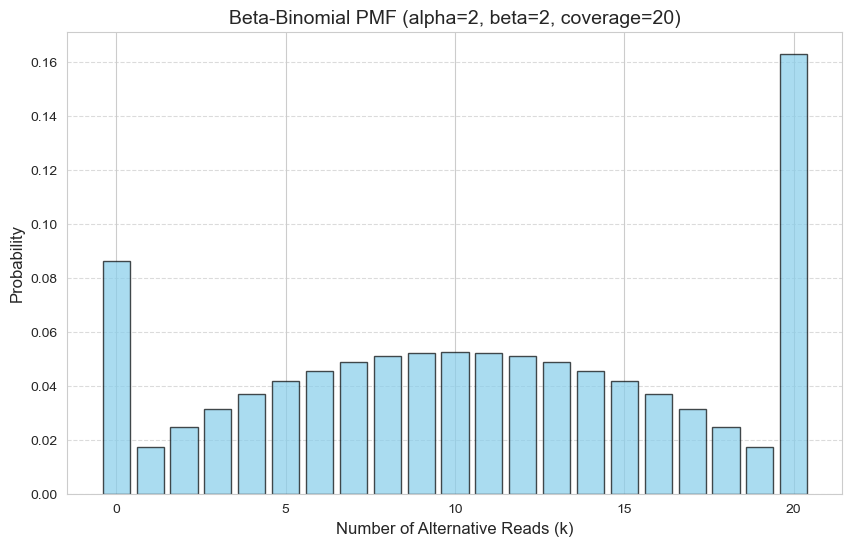

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb
from scipy.special import gamma

# Define the beta-binomial PMF
def beta_binomial_pmf(k, r, alpha, beta, drop_ref, drop_alt):
    """
    k: Number of alternative reads
    r: Total sequencing coverage
    alpha: Shape parameter for alternative allele
    beta: Shape parameter for reference allele
    """
    numerator = comb(r, k) * gamma(k + alpha) * gamma(r - k + beta) * gamma(alpha + beta)
    denominator = gamma(alpha) * gamma(beta) * gamma(r + alpha + beta)
    pmf = numerator / denominator
    
    if k == 0:
        pmf += drop_ref
    if k == r:
        pmf += drop_alt
    return pmf

# Define parameters
alpha = 2  # Variant allele parameter
beta = 2   # Reference allele parameter
r = 20     # Sequencing coverage (total reads)
k_values = np.arange(0, r + 1)  # Possible read counts (0 to r)
mono_ref = 0.1
mono_alt = 0.2

# Compute the beta-binomial probabilities
probabilities = ([beta_binomial_pmf(k, r, alpha, beta, mono_ref, mono_alt) for k in k_values])
probabilities /= np.sum(probabilities)

# Plot the beta-binomial PMF
plt.figure(figsize=(10, 6))
plt.bar(k_values, probabilities, color="skyblue", edgecolor="black", alpha=0.7)
plt.title(f"Beta-Binomial PMF (alpha={alpha}, beta={beta}, coverage={r})", fontsize=14)
plt.xlabel("Number of Alternative Reads (k)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

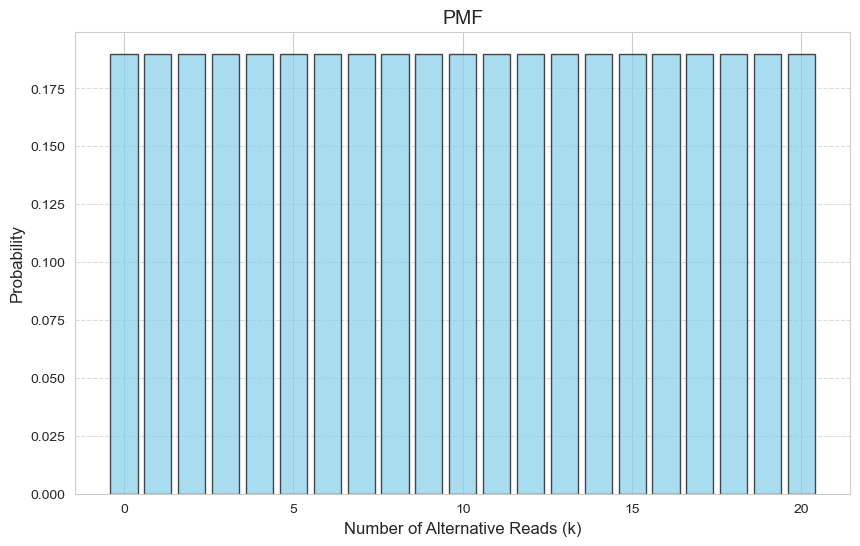

In [9]:
from math import comb

def compute_probability(c_r, c_a, mu):
    """
    Computes the probability P(A_ij | D_ij, c_r, c_a, mu, epsilon, omega_hom, omega_het).
    
    Parameters:
        A_ij: Number of alternative reads observed
        D_ij: Total reads (sequencing depth)
        c_r: Number of reference alleles
        c_a: Number of alternative alleles
        mu: Dropout rate

    Returns:
        Probability P(A_ij | ...)
    """
    total_probability = 0

    # Iterate over all possible values of k and l (except k=l=0)
    # calculate the probabilities of each number of alternative/reference alleles being lost
    for q in range(c_r + 1):
        for p in range(c_a + 1):
            if q == 0 and p == 0:
                continue
            
            # Binomial coefficients for reference and alternative alleles lost
            binomial_ref = comb(c_r, q)
            binomial_alt = comb(c_a, p)
            
            dropout_prob = ((1-mu) ** (c_r + c_a - p - q)) * ((mu) ** (p + q))
            
            total_probability += binomial_ref * binomial_alt * dropout_prob 

    return total_probability

r = 20     # Sequencing coverage (total reads)
k_values = np.arange(0, r + 1)  # Possible alternative read counts (0 to r)

# Compute the beta-binomial probabilities
probabilities = [compute_probability(1, 1, 0.1) for k in k_values]

plt.figure(figsize=(10, 6))
plt.bar(k_values, probabilities, color="skyblue", edgecolor="black", alpha=0.7)
plt.title(f"PMF", fontsize=14)
plt.xlabel("Number of Alternative Reads (k)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
import numpy as np
import pandas as pd
from scipy.special import beta as beta_func
from scipy.optimize import minimize
from scipy.special import betaln
from scipy.optimize import minimize_scalar

def Estep(a, b, phi, epsilon, nA, nB):
    # phi: expected probabilities over all cells
    # Calculate the probabilities for each category
    prob_off = (epsilon ** (nA + nB)) * phi[0] # gene switched off
    prob_a = ((1 - epsilon) ** nA) * (epsilon ** nB) * phi[1] # prob allele A expressed
    prob_b = (epsilon ** nA) * ((1 - epsilon) ** nB) * phi[2] # prob allele B expressed
    # beta_func(a, b) corresponds to the relative expression of A allele when both alleles are expressed
    prob_ab = ((1 - epsilon) ** (nA + nB)) * (beta_func(nA + a, nB + b) / beta_func(a, b)) * phi[3] # AB

    # Apply hard call conditions
    hardcall1 = (nA <= 1) & (nB <= 1) # if both ref and alt read counts are 1 or smaller in this cell, the gene is counted as not expressed in this cell.
    prob_off[hardcall1] = 1
    prob_a[hardcall1] = 0
    prob_b[hardcall1] = 0
    prob_ab[hardcall1] = 0

    hardcall2 = (nA >= 20) & (nB >= 20) # if both ref and alt read counts are larger than 20 in a cell, both alleles are counted as expressed in this cell.
    prob_off[hardcall2] = 0
    prob_a[hardcall2] = 0
    prob_b[hardcall2] = 0
    prob_ab[hardcall2] = 1

    # Combine probabilities into Zhat and normalize
    Zhat = np.column_stack((prob_off, prob_a, prob_b, prob_ab))
    Zhat = Zhat / Zhat.sum(axis=1, keepdims=True)
    
    return Zhat


def Mstep(Zhat, cura, n_cells, nA, nB):
    # Calculate phihat
    phihat = Zhat.sum(axis=0) / n_cells
    phihat = np.maximum(phihat, 0.01)
    phihat /= phihat.sum()

    # Define the objective function
    def objective(x):
        a = b = x
        likelihood = np.sum(Zhat[:, 3] * (betaln(nA + a, nB + b) - betaln(a, b)))
        return -likelihood  # Minimize negative log-likelihood

    result = minimize_scalar(objective, bounds=(3, 100), method='bounded')

    a_b = result.x if result.success else cura  # Fallback to cura if optimization fails

    return {"phihat": phihat, "a.b": a_b}

# def Mstep(Zhat, cura, currb, n_cells, nA, nB):
#     # Calculate phihat
#     phihat = Zhat.sum(axis=0) / n_cells
#     phihat = np.maximum(phihat, 0.01)
#     phihat /= phihat.sum()
# 
#     # Define the objective function for independent a and b
#     def objective(params):
#         a, b = params
#         if a < 1 or b < 1:  # Ensure a and b are >= 1
#             return np.inf
#         likelihood = np.sum(Zhat[:, 3] * (betaln(nA + a, nB + b) - betaln(a, b)))
#         return -likelihood  # Minimize negative log-likelihood
# 
#     # Initial guesses for a and b
#     initial_guess = [cura, currb]
# 
#     # Bounds for a and b (both must be >= 1)
#     bounds = [(1, 100), (1, 100)]
# 
#     # Optimize a and b independently
#     result = minimize(
#         lambda x: objective(x),
#         x0=initial_guess,
#         bounds=bounds,
#         method="L-BFGS-B"
#     )
# 
#     if result.success:
#         a, b = result.x
#     else:
#         a, b = cura, currb  # Fallback to cura and currb if optimization fails
# 
#     return {"phihat": phihat, "a": a, "b": b}


def gene_classify(alleleA, alleleB, epsilon=0.001):
    num_genes = len(alleleA.columns)
    gene_category = np.full(num_genes, None, dtype=object)
    A_prop = np.full(num_genes, np.nan)
    B_prop = np.full(num_genes, np.nan)
    results_list = [None] * num_genes
    n_cells = alleleA.shape[0]
    gene_names = alleleA.columns

    for i in range(num_genes):
        nA = alleleA.iloc[:, i].values
        nB = alleleB.iloc[:, i].values
        k = 4
        a = b = cura = 1
        phi = np.full(k, 1 / k)
        diff = 1
        num_iters = 1

        while diff > 0.0001 or num_iters <= 30:
            num_iters += 1
            Zhat = Estep(a, b, phi, epsilon, nA, nB)
            curM = Mstep(Zhat, cura, n_cells, nA, nB) # consider optimizing both a and b
            curphi = curM["phihat"]
            cura = curb = curM["a.b"]
            diff = max(np.max(np.abs(phi - curphi)), np.max(np.abs(a - cura)))
            phi = curphi
            a = b = cura
            if num_iters >= 3000:
                break

        cell_post_filter = Zhat.max(axis=1) > 0.8
        category = np.array(["Off", "A", "B", "AB"])
        filtered_Zhat = Zhat[cell_post_filter]
        result_counts = pd.Series(
            category[np.argmax(filtered_Zhat, axis=1)]
        ).value_counts()
        results_list[i] = result_counts.to_dict()

        if set(result_counts.index) == {"Off"}:
            gene_cate = "Silent"
        elif set(result_counts.index) <= {"A", "Off"}:
            gene_cate = "MonoA"
        elif set(result_counts.index) <= {"B", "Off"}:
            gene_cate = "MonoB"
        else:
            gene_cate = "Biallelic"

        if "Off" not in result_counts:
            result_counts["Off"] = 0
        if "AB" not in result_counts:
            result_counts["AB"] = 0
        if "A" not in result_counts:
            result_counts["A"] = 0
        if "B" not in result_counts:
            result_counts["B"] = 0

        A_prop[i] = round((result_counts["A"] + result_counts["AB"]) / result_counts.sum(), 3)
        B_prop[i] = round((result_counts["B"] + result_counts["AB"]) / result_counts.sum(), 3)

        if 0.05 <= A_prop[i] <= 0.95 and 0.05 <= B_prop[i] <= 0.95:
            gene_cate = "Biallelic.bursty"

        gene_category[i] = gene_cate
        print(f"Gene {i + 1}: {gene_names[i]}, {gene_cate}\tA prop {A_prop[i]} B prop {B_prop[i]}")

    gene_category = np.where(gene_category == "Biallelic", "Biallelic.nonbursty", gene_category)
    return {"gene_category": gene_category, "A_prop": A_prop, "B_prop": B_prop, "results_list": results_list}

classification = gene_classify(reference.fillna(0), alternative.fillna(0))

Gene 1: chr10:1000772:G:A, Biallelic.bursty	A prop 0.252 B prop 0.315
Gene 2: chr10:100233142:T:C, Biallelic.bursty	A prop 0.165 B prop 0.071
Gene 3: chr10:101691868:C:A, MonoB	A prop 0.0 B prop 0.244
Gene 4: chr10:1017501:T:G, MonoB	A prop 0.0 B prop 0.291
Gene 5: chr10:1017507:A:G, MonoB	A prop 0.0 B prop 0.283
Gene 6: chr10:101785320:A:G, MonoB	A prop 0.0 B prop 0.213
Gene 7: chr10:102163139:G:T, Biallelic.bursty	A prop 0.317 B prop 0.325
Gene 8: chr10:102163251:G:A, Biallelic.bursty	A prop 0.184 B prop 0.096
Gene 9: chr10:102424324:G:A, Biallelic.bursty	A prop 0.185 B prop 0.202
Gene 10: chr10:102676884:C:T, Biallelic.bursty	A prop 0.236 B prop 0.236
Gene 11: chr10:103394332:A:G, Biallelic	A prop 0.024 B prop 0.228
Gene 12: chr10:103395888:T:C, MonoB	A prop 0.0 B prop 0.402
Gene 13: chr10:103897558:G:C, MonoB	A prop 0.0 B prop 0.331
Gene 14: chr10:103897605:C:G, Biallelic.bursty	A prop 0.165 B prop 0.22
Gene 15: chr10:103900068:T:C, MonoB	A prop 0.0 B prop 0.276
Gene 16: chr10:1039

In [11]:
classification

{'gene_category': array(['Biallelic.bursty', 'Biallelic.bursty', 'MonoB', ...,
        'Biallelic.nonbursty', 'MonoB', 'MonoB'], dtype=object),
 'A_prop': array([0.252, 0.165, 0.   , ..., 0.008, 0.   , 0.   ]),
 'B_prop': array([0.315, 0.071, 0.244, ..., 0.591, 0.575, 0.268]),
 'results_list': [{'Off': 74, 'B': 21, 'AB': 19, 'A': 13},
  {'Off': 100, 'A': 18, 'B': 6, 'AB': 3},
  {'Off': 96, 'B': 31},
  {'Off': 90, 'B': 37},
  {'Off': 91, 'B': 36},
  {'Off': 100, 'B': 27},
  {'Off': 68, 'AB': 23, 'B': 18, 'A': 17},
  {'Off': 102, 'AB': 12, 'A': 11},
  {'Off': 84, 'B': 17, 'A': 15, 'AB': 8},
  {'Off': 77, 'B': 20, 'A': 20, 'AB': 10},
  {'Off': 96, 'B': 28, 'A': 2, 'AB': 1},
  {'Off': 76, 'B': 51},
  {'Off': 85, 'B': 42},
  {'Off': 85, 'B': 21, 'A': 14, 'AB': 7},
  {'Off': 92, 'B': 35},
  {'Off': 101, 'B': 13, 'A': 10, 'AB': 3},
  {'Off': 103, 'A': 23, 'B': 1},
  {'Off': 85, 'B': 19, 'A': 15, 'AB': 7},
  {'Off': 81, 'A': 22, 'B': 17, 'AB': 7},
  {'Off': 100, 'B': 12, 'A': 12, 'AB': 3},
  {

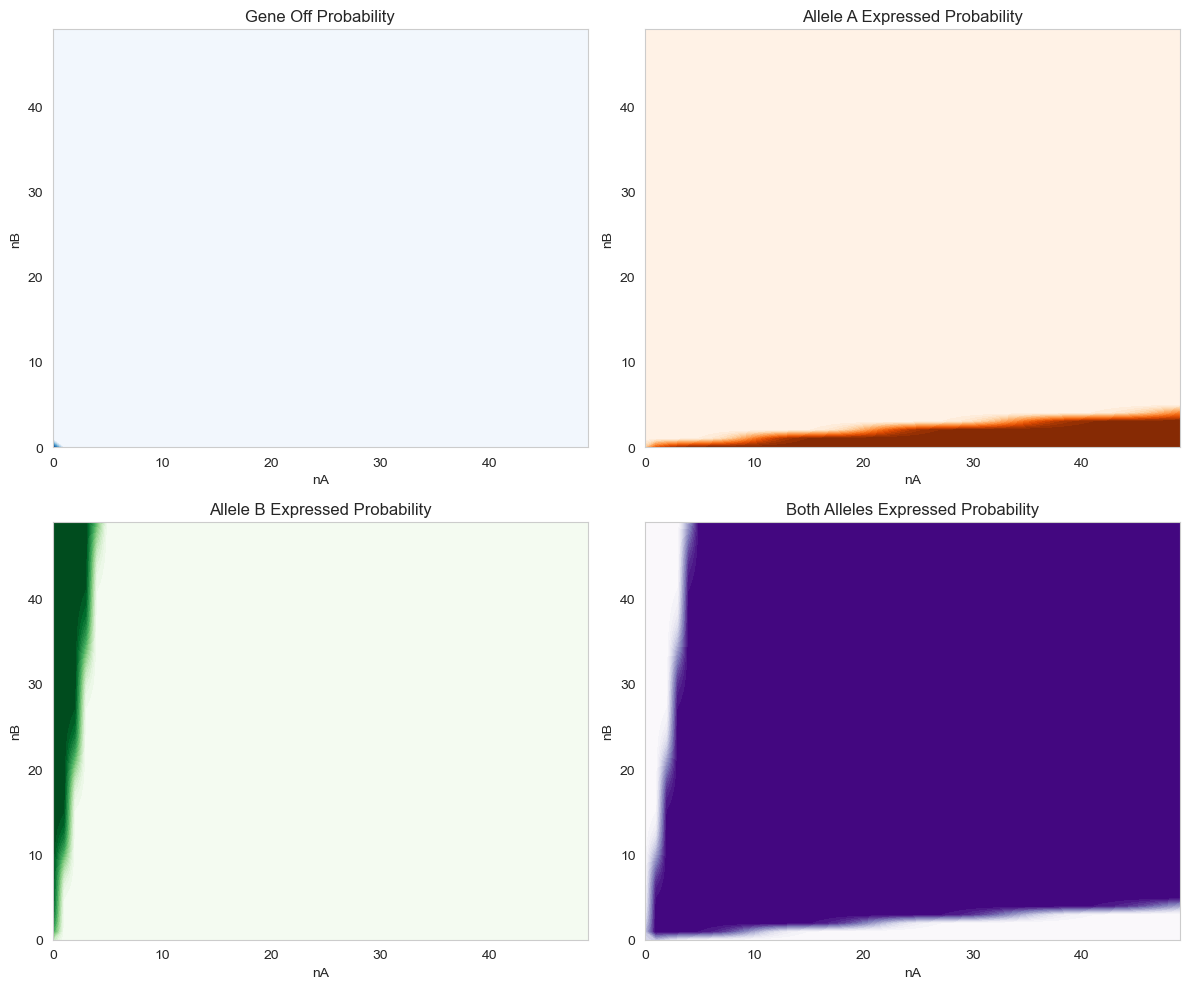

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta as beta_func

# Define the Estep function
def Estep(a, b, phi, epsilon, nA, nB):
    # Calculate the probabilities for each category
    binom_coeff = comb(nA + nB, nA)
    prob_off = binom_coeff * (epsilon ** (nA + nB)) * phi[0]  # Gene switched off
    prob_a = binom_coeff * ((1 - epsilon) ** nA) * (epsilon ** nB) * phi[1]  # Only allele A expressed
    prob_b = binom_coeff * (epsilon ** nA) * ((1 - epsilon) ** nB) * phi[2]  # Only allele B expressed
    prob4 = binom_coeff * ((1 - epsilon) ** (nA + nB)) * (beta_func(nA + a, nB + b) / beta_func(a, b)) * phi[3]
    
    # prob_off = (epsilon ** (nA + nB)) * phi[0] # gene switched off
    # prob_a = ((1 - epsilon) ** nA) * (epsilon ** nB) * phi[1] # prob allele A expressed
    # prob_b = (epsilon ** nA) * ((1 - epsilon) ** nB) * phi[2] # prob allele B expressed
    # prob4 = ((1 - epsilon) ** (nA + nB)) * (beta_func(nA + a, nB + b) / beta_func(a, b)) * phi[3] # both alleles expressed
    total_prob = prob_off + prob_a + prob_b + prob4  # total probability for normalization
    
    # Normalize the probabilities
    prob_off /= total_prob
    prob_a /= total_prob
    prob_b /= total_prob
    prob4 /= total_prob
    
    return prob_off, prob_a, prob_b, prob4

# Set parameters
epsilon = 0.001
a = 30
b = 30
phi = [0.25, 0.25, 0.25, 0.25]  # equal weights for all categories

# Create a grid of nA and nB values
nA_values = np.arange(0, 50)
nB_values = np.arange(0, 50)

# Prepare a meshgrid for plotting
N_A, N_B = np.meshgrid(nA_values, nB_values)

# Compute probabilities for each nA, nB pair
prob_off_values = np.zeros(N_A.shape)
prob_a_values = np.zeros(N_A.shape)
prob_b_values = np.zeros(N_A.shape)
prob4_values = np.zeros(N_A.shape)

for i in range(N_A.shape[0]):
    for j in range(N_A.shape[1]):
        nA = N_A[i, j]
        nB = N_B[i, j]
        prob_off, prob_a, prob_b, prob4 = Estep(a, b, phi, epsilon, nA, nB)
        
        prob_off_values[i, j] = prob_off
        prob_a_values[i, j] = prob_a
        prob_b_values[i, j] = prob_b
        prob4_values[i, j] = prob4

# Plotting the normalized probabilities
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot each probability
ax[0, 0].contourf(N_A, N_B, prob_off_values, 20, cmap='Blues')
ax[0, 0].set_title("Gene Off Probability")
ax[0, 0].set_xlabel("nA")
ax[0, 0].set_ylabel("nB")

ax[0, 1].contourf(N_A, N_B, prob_a_values, 20, cmap='Oranges')
ax[0, 1].set_title("Allele A Expressed Probability")
ax[0, 1].set_xlabel("nA")
ax[0, 1].set_ylabel("nB")

ax[1, 0].contourf(N_A, N_B, prob_b_values, 20, cmap='Greens')
ax[1, 0].set_title("Allele B Expressed Probability")
ax[1, 0].set_xlabel("nA")
ax[1, 0].set_ylabel("nB")

ax[1, 1].contourf(N_A, N_B, prob4_values, 20, cmap='Purples')
ax[1, 1].set_title("Both Alleles Expressed Probability")
ax[1, 1].set_xlabel("nA")
ax[1, 1].set_ylabel("nB")

plt.tight_layout()
plt.show()

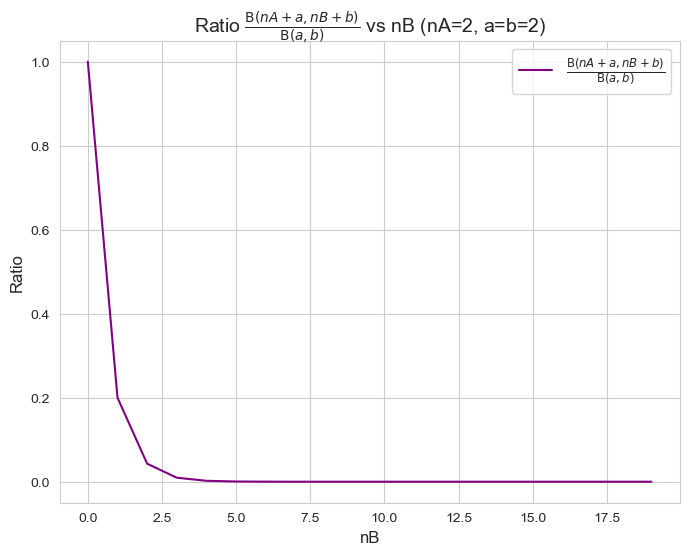

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta as beta_func

# Parameters
a = 2
b = 2
nA = 5

# Generate a range of nB values
nB_values = np.arange(0, 20)

# Calculate the ratio (beta_func(nA + a, nB + b) / beta_func(a, b)) for each nB
ratios = [beta_func(nB + a, nB + b) / beta_func(a, b) for nB in nB_values]

# Plot the ratio as a function of nB
plt.figure(figsize=(8, 6))
plt.plot(nB_values, ratios, label=r'$\frac{\mathrm{B}(nA + a, nB + b)}{\mathrm{B}(a, b)}$', color='purple')
plt.title(r'Ratio $\frac{\mathrm{B}(nA + a, nB + b)}{\mathrm{B}(a, b)}$ vs nB (nA=2, a=b=2)', fontsize=14)
plt.xlabel('nB', fontsize=12)
plt.ylabel('Ratio', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

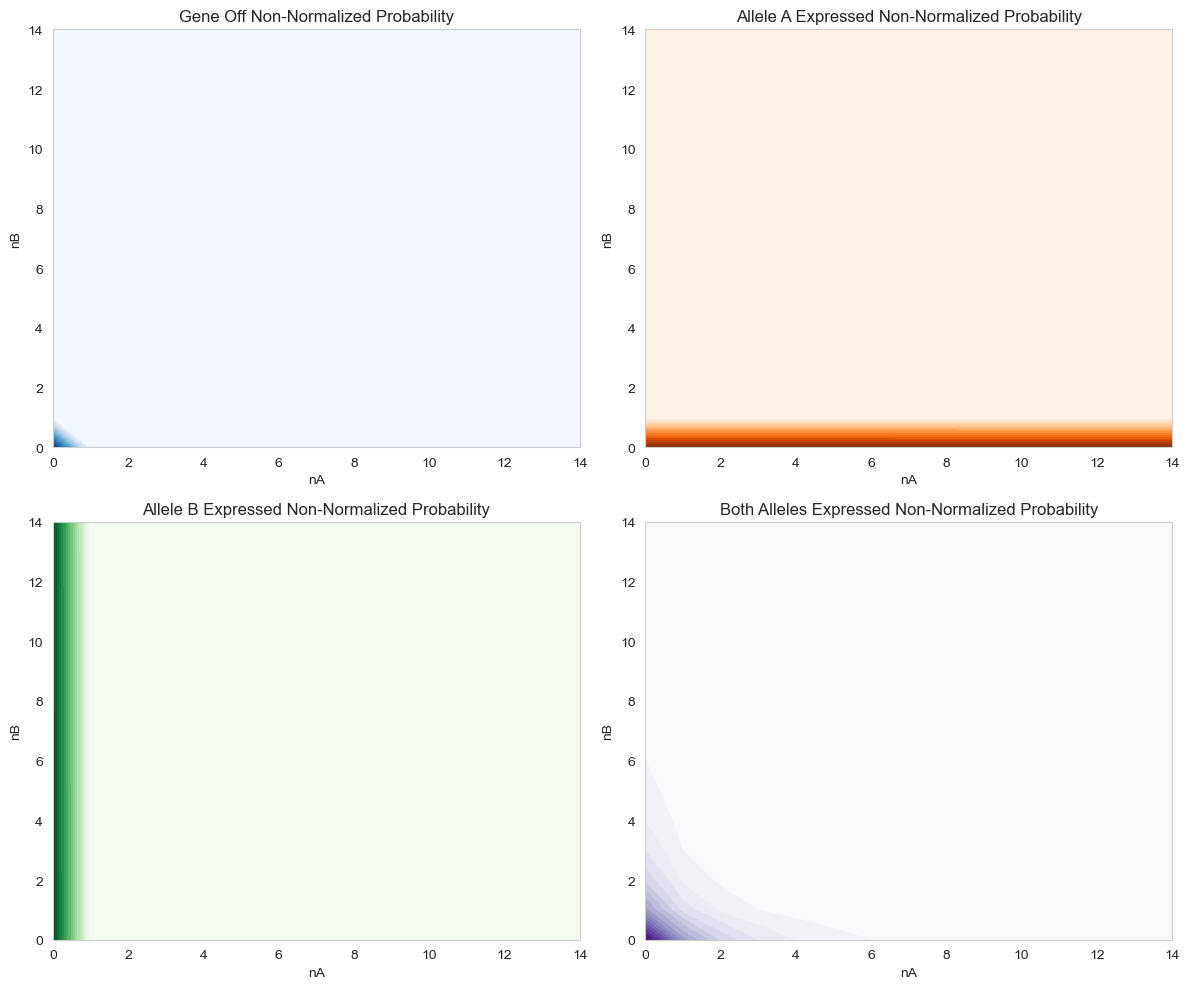

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta as beta_func

# Define the Estep function without normalization
def Estep_non_normalized(a, b, phi, epsilon, nA, nB):
    # Calculate the non-normalized probabilities for each category
    prob_off = (epsilon ** (nA + nB)) * phi[0] # gene switched off
    prob_a = ((1 - epsilon) ** nA) * (epsilon ** nB) * phi[1] # prob allele A expressed
    prob_b = (epsilon ** nA) * ((1 - epsilon) ** nB) * phi[2] # prob allele B expressed
    prob4 = ((1 - epsilon) ** (nA + nB)) * (beta_func(nA + a, nB + b) / beta_func(a, b)) * phi[3] # both alleles expressed
    return prob_off, prob_a, prob_b, prob4

# Set parameters
epsilon = 0.001
a = 3
b = 3
phi = [0.25, 0.25, 0.25, 0.25]  # equal weights for all categories

# Create a grid of nA and nB values
nA_values = np.arange(0, 15)
nB_values = np.arange(0, 15)

# Prepare a meshgrid for plotting
N_A, N_B = np.meshgrid(nA_values, nB_values)

# Compute non-normalized probabilities for each nA, nB pair
prob_off_values = np.zeros(N_A.shape)
prob_a_values = np.zeros(N_A.shape)
prob_b_values = np.zeros(N_A.shape)
prob4_values = np.zeros(N_A.shape)

for i in range(N_A.shape[0]):
    for j in range(N_A.shape[1]):
        nA = N_A[i, j]
        nB = N_B[i, j]
        prob_off, prob_a, prob_b, prob4 = Estep_non_normalized(a, b, phi, epsilon, nA, nB)
        
        prob_off_values[i, j] = prob_off
        prob_a_values[i, j] = prob_a
        prob_b_values[i, j] = prob_b
        prob4_values[i, j] = prob4

# Plotting the non-normalized probabilities
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot each probability
ax[0, 0].contourf(N_A, N_B, prob_off_values, 20, cmap='Blues')
ax[0, 0].set_title("Gene Off Non-Normalized Probability")
ax[0, 0].set_xlabel("nA")
ax[0, 0].set_ylabel("nB")

ax[0, 1].contourf(N_A, N_B, prob_a_values, 20, cmap='Oranges')
ax[0, 1].set_title("Allele A Expressed Non-Normalized Probability")
ax[0, 1].set_xlabel("nA")
ax[0, 1].set_ylabel("nB")

ax[1, 0].contourf(N_A, N_B, prob_b_values, 20, cmap='Greens')
ax[1, 0].set_title("Allele B Expressed Non-Normalized Probability")
ax[1, 0].set_xlabel("nA")
ax[1, 0].set_ylabel("nB")

ax[1, 1].contourf(N_A, N_B, prob4_values, 20, cmap='Purples')
ax[1, 1].set_title("Both Alleles Expressed Non-Normalized Probability")
ax[1, 1].set_xlabel("nA")
ax[1, 1].set_ylabel("nB")

plt.tight_layout()
plt.show()